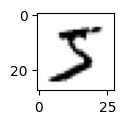

In [76]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_val, y_val = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_val, X_test = X_train/255., X_val/255., X_test/255.

plt.figure(figsize=(1,1))
plt.imshow(X_train[0].reshape(28, 28), cmap='Greys', )

In [77]:
import keras.backend as K

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28,28]),
    tf.keras.layers.Dense(300, activation='relu'), 
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(20, activation='softmax')
])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
expo_lr = ExponentialLearningRate(1.005)


In [78]:
# Increase learning rate exponentially to find point where loss shoots up. Optimal learning rate is half of that value

history = model.fit(X_train, y_train, epochs=1, validation_data=(X_val, y_val), callbacks=[expo_lr])

1719/1719 [==============================] - 4s 2ms/step - loss: 22.6425 - accuracy: 0.5739 - val_loss: 2.3881 - val_accuracy: 0.1060


Text(0, 0.5, 'Loss')

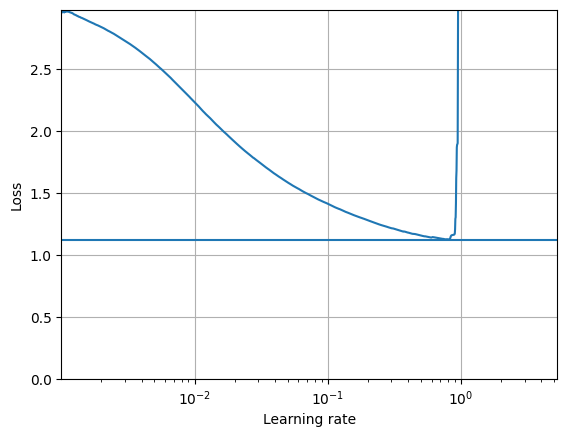

In [79]:
plt.plot(expo_lr.rates, expo_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expo_lr.losses), min(expo_lr.rates), max(expo_lr.rates))
plt.axis([min(expo_lr.rates), max(expo_lr.rates), 0, expo_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [82]:
# Redefine and retrain model with optimal learning rate. 

tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=3e-1)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2346 - accuracy: 0.9270 - val_loss: 0.1072 - val_accuracy: 0.9664
Epoch 2/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0941 - accuracy: 0.9708 - val_loss: 0.0800 - val_accuracy: 0.9768
Epoch 3/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0682 - accuracy: 0.9785 - val_loss: 0.0807 - val_accuracy: 0.9774
Epoch 4/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0495 - accuracy: 0.9835 - val_loss: 0.0739 - val_accuracy: 0.9778
Epoch 5/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0360 - accuracy: 0.9880 - val_loss: 0.0717 - val_accuracy: 0.9832
Epoch 6/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0286 - accuracy: 0.9903 - val_loss: 0.0944 - val_accuracy: 0.9758
Epoch 7/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0223 - accuracy: 0.9928 - val_loss: 0.0833 - val_accuracy:

In [83]:
# Evaluate model with optimal training rate
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0750 - accuracy: 0.9868


[0.07501762360334396, 0.9868000149726868]

In [85]:
# Add hyperparameter tuning: save checkpoints, early stopping and tensorboard plots

from pathlib import Path
root_logdir = Path("./save_model/")
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20)
save_checkpoints = tf.keras.callbacks.ModelCheckpoint("./save_model/mnist_model", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard()

tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=3e-1)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping, tensorboard_cb, save_checkpoints])

Epoch 1/100
1712/1719 [============================>.] - ETA: 0s - loss: 0.2359 - accuracy: 0.9274

INFO:tensorflow:Assets written to: ./save_model\mnist_model\assets


INFO:tensorflow:Assets written to: ./save_model\mnist_model\assets


1719/1719 [==============================] - 4s 2ms/step - loss: 0.2356 - accuracy: 0.9275 - val_loss: 0.0954 - val_accuracy: 0.9694
Epoch 2/100
1699/1719 [============================>.] - ETA: 0s - loss: 0.0953 - accuracy: 0.9708

INFO:tensorflow:Assets written to: ./save_model\mnist_model\assets


INFO:tensorflow:Assets written to: ./save_model\mnist_model\assets


1719/1719 [==============================] - 4s 2ms/step - loss: 0.0954 - accuracy: 0.9707 - val_loss: 0.0839 - val_accuracy: 0.9748
Epoch 3/100
1717/1719 [============================>.] - ETA: 0s - loss: 0.0661 - accuracy: 0.9785

INFO:tensorflow:Assets written to: ./save_model\mnist_model\assets


INFO:tensorflow:Assets written to: ./save_model\mnist_model\assets


1719/1719 [==============================] - 4s 2ms/step - loss: 0.0661 - accuracy: 0.9785 - val_loss: 0.0754 - val_accuracy: 0.9806
Epoch 4/100
1694/1719 [============================>.] - ETA: 0s - loss: 0.0490 - accuracy: 0.9840

INFO:tensorflow:Assets written to: ./save_model\mnist_model\assets


INFO:tensorflow:Assets written to: ./save_model\mnist_model\assets


1719/1719 [==============================] - 4s 2ms/step - loss: 0.0493 - accuracy: 0.9839 - val_loss: 0.0697 - val_accuracy: 0.9788
Epoch 5/100
1700/1719 [============================>.] - ETA: 0s - loss: 0.0354 - accuracy: 0.9885

INFO:tensorflow:Assets written to: ./save_model\mnist_model\assets


INFO:tensorflow:Assets written to: ./save_model\mnist_model\assets


1719/1719 [==============================] - 4s 3ms/step - loss: 0.0353 - accuracy: 0.9885 - val_loss: 0.0688 - val_accuracy: 0.9826
Epoch 6/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0285 - accuracy: 0.9909 - val_loss: 0.1058 - val_accuracy: 0.9754
Epoch 7/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0246 - accuracy: 0.9919 - val_loss: 0.0706 - val_accuracy: 0.9820
Epoch 8/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0207 - accuracy: 0.9931 - val_loss: 0.0817 - val_accuracy: 0.9792
Epoch 9/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0142 - accuracy: 0.9954 - val_loss: 0.0857 - val_accuracy: 0.9814
Epoch 10/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0119 - accuracy: 0.9962 - val_loss: 0.0841 - val_accuracy: 0.9824
Epoch 11/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0110 - accuracy: 0.9963 - val_loss: 0.0904 - val_accuracy: 0.

In [86]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0825 - accuracy: 0.9854


[0.08251676708459854, 0.9854000210762024]